# INF-0616 - Projeto 2: *SVR, Grid Search & Random Search*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br Hudson Bruno -- hudson.bruno@ic.unicamp.br

Este notebook faz parte da disciplina INF-0616 no curso de extensão MDC.
Demais artefatos podem ser encontrados no moodle da disciplina: moodle.lab.ic.unicamp.br/456

Instituto de Computação - Unicamp 2021

In [1]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns

from IPython.display import display

## PARTE I - Support Vector Machine Regressors

O conjunto *Doctor fees prediction* contém uma relação entre um conjunto de características associadas a um médico atendente e o preço da consulta cobrada. O objetivo é **regredir** este valor o mais próximo possível do valor esperado.   
Ele pode ser encontrado no moodle, junto com a atividade, ou no seguinte link: [kaggle.com/nitin194/doctor-fees-prediction](https://www.kaggle.com/nitin194/doctor-fees-prediction)

In [2]:
train = pd.read_csv('./doctor-fees-train.csv')
train, test = train_test_split(train, test_size=.3, random_state=7128)

#### Pré-processamento dos dados para um formato mais limpo

- Converte a coluna `Rating` para porcentagens
- Converte a coluna `Experience` para um número (em anos)
- Simplifica as colunas `Qualification` e `Place`, removendo caracteres especiais e transformando tudo em minúsculo

In [3]:
def preprocess(frame):
    frame['Rating'] = frame['Rating'].str.replace('%', '').astype(float) / 100.0
    frame['Experience'] = frame['Experience'].str.replace('years experience', '').astype(float)
    frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
    frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()

preprocess(train)
preprocess(test)

C:\Users\HOME41~1\AppData\Local\Temp/ipykernel_15120/1485874194.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
C:\Users\HOME41~1\AppData\Local\Temp/ipykernel_15120/1485874194.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()


- Remove uma linha inválida, contendo `"years experience"` como valor para a coluna qualificação

In [4]:
invalid_rows = train['Qualification'].str.contains('years experience')
train = train[~invalid_rows]

- Preenche todas as células das colunas `Place` e `Profile` com valor igual à `NaN` com a tag `unknown`

In [5]:
train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
test.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,bds mds conservative dentistry endodontics,6.0,NaN,nungambakkam chennai,Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,balapur hyderabad,General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,md dermatology venereology leprosy mbbs,17.0,NaN,manikonda hyderabad,Dermatologists,NaN,350
1992,bams,10.0,1.0,konanakunte bangalore,Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,vidyanagar hyderabad,Homeopath,NaN,200


### Exibindo frequência com que as qualificações, locais e perfis ocorrem nos conjuntos

In [6]:
def plot_feature_freq(frame, feature, showing=30):
    labels, counts = np.unique(frame[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    g = sns.barplot(labels[:showing], counts[:showing])
    g.set_xticklabels(labels[:showing], rotation=90)
    
    return g

C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


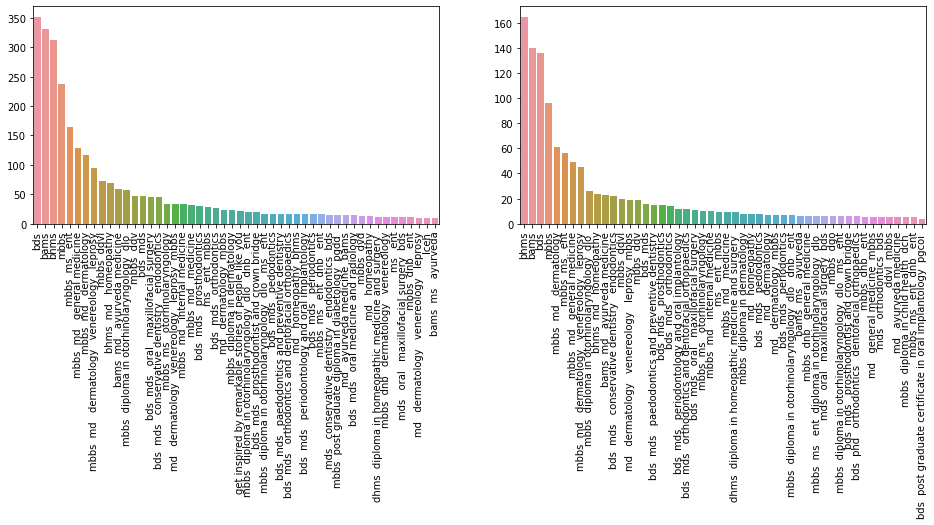

In [7]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Qualification', showing=50)

plt.subplot(122)
plot_feature_freq(test, 'Qualification', showing=50)

# Ordena as qualificações pelas mais frequentes.
qualifications, counts = np.unique(train['Qualification'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
qualifications = qualifications[p];

C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


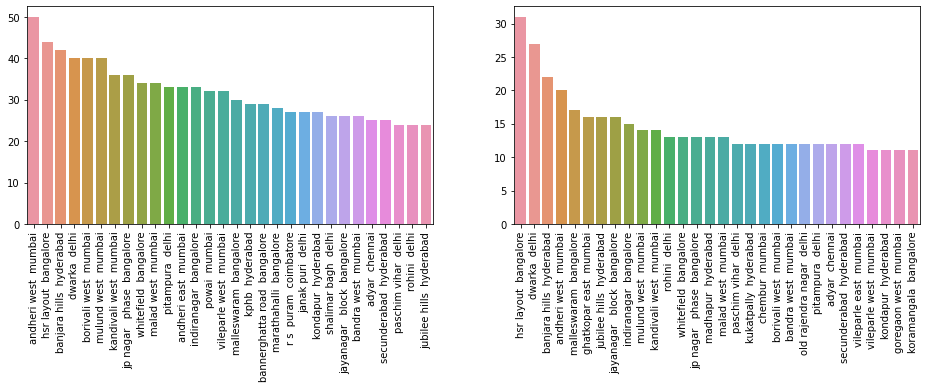

In [8]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Place')

plt.subplot(122)
plot_feature_freq(test, 'Place')

# Ordena os locais pelos mais frequentes.
places, counts = np.unique(train['Place'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
places = places[p];

C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


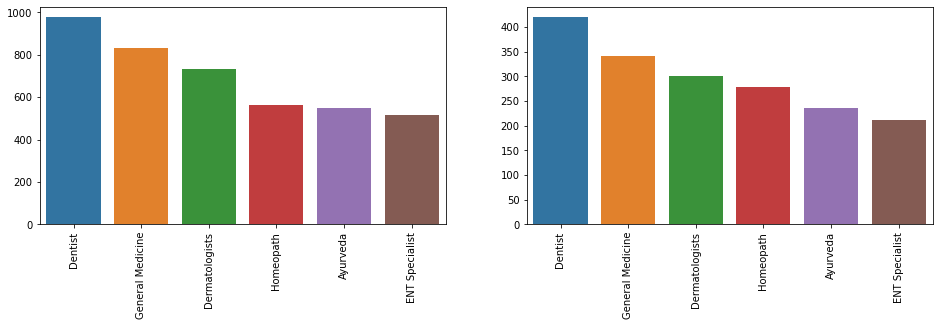

In [9]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Profile')

plt.subplot(122)
plot_feature_freq(test, 'Profile');

### Modelando um regressor de custo de consulta

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Vamos codificar as características categóricas usando o one-hot encoding.
Entretanto, dado o alto número de ocorrências únicas, nós consideramos somente os 100 valores de maior frequência.

In [11]:
retained_qualif = qualifications[:100].tolist()
retained_places = places[:100].tolist()

qualif_places_enc = OneHotEncoder(categories=[retained_qualif, retained_places],
                                  handle_unknown='ignore')
profile_enc = OneHotEncoder()

Substituímos as células desconhecidas pelo valor mediano e normalizamos as características contínuas com o `StandardScaler`, o que os transforma em um conjunto de média 0, desvio padrão 1:

In [12]:
continuous_enc = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())

Compomos o pipeline, definindo quais colunas alimentarão quais codificadores, e aplicamos o transformador aos dados de entrada e aos valores de saída:

In [13]:
encoder = ColumnTransformer([
  ('q_pla', qualif_places_enc, ['Qualification', 'Place']),
  ('prof', profile_enc, ['Profile']),
  ('ex_ra', continuous_enc, ['Experience', 'Rating'])
])

train_e = encoder.fit_transform(train)
# Apesar da normalização ser imprescindível, ela está acontecendo no conjunto de teste com os parâmetros 
# que encontramos no cnjunto de treino. Logo, não estamos usando informação do teste, mas apenas adequando a
# faixa de valores para a faixa com a qual o modelo foi treinado.
test_e = encoder.transform(test)

fee_enc = StandardScaler()
ye_train = fee_enc.fit_transform(train[['Fees']].astype(float)).ravel()
ye_test = fee_enc.transform(test[['Fees']].astype(float)).ravel()

In [14]:
pd.DataFrame.sparse.from_spmatrix(train_e)

,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.018123,0.196602
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.749289,0.196602
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.032398,0.196602
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.659678,0.756092
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.555791,0.196602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.057213,0.196602
4167,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.146824,-0.362888
4168,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.387108,0.196602
4169,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.107734,0.196602


In [111]:
len(ye_train)

4171

# obs: não entendi pq transformar as saídas

**Atividade (3 pts):** treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, epislon) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, epislon) afetaramm a qualidade do seus regressores. A busca pelos hiperparâmetros deve usar um método formal como GridSerach, RandomSearch, etc.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import time

In [40]:
kernel = ["linear","poly","rbf","sigmoid"]
#gamma = [0.0001, 0.01, 0.1, 1, 10, 100]
C = [0.0001, 0.01, 1, 10, 100]
epsilon = [0.1,0.2,0.6,1,2,4]
parameters = [{'kernel': kernel ,
               #'gamma': gamma,
               'C': C,
               'epsilon': epsilon}]

cv_folds = 5


In [42]:
start_time = time.time()
svr = GridSearchCV(SVR(), parameters, cv = cv_folds, scoring  = "neg_mean_absolute_error" , verbose=3)
svr.fit(train_e, ye_train)
end_time = time.time()
print("total time {:.2f} seconds".format( end_time - start_time))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END C=0.0001, epsilon=0.1, kernel=linear;, score=-0.789 total time=   0.3s
[CV 2/5] END C=0.0001, epsilon=0.1, kernel=linear;, score=-0.796 total time=   0.3s
[CV 3/5] END C=0.0001, epsilon=0.1, kernel=linear;, score=-0.819 total time=   0.3s
[CV 4/5] END C=0.0001, epsilon=0.1, kernel=linear;, score=-0.823 total time=   0.3s
[CV 5/5] END C=0.0001, epsilon=0.1, kernel=linear;, score=-0.804 total time=   0.3s
[CV 1/5] END C=0.0001, epsilon=0.1, kernel=poly;, score=-0.797 total time=   0.3s
[CV 2/5] END C=0.0001, epsilon=0.1, kernel=poly;, score=-0.807 total time=   0.3s
[CV 3/5] END C=0.0001, epsilon=0.1, kernel=poly;, score=-0.824 total time=   0.3s
[CV 4/5] END C=0.0001, epsilon=0.1, kernel=poly;, score=-0.828 total time=   0.3s
[CV 5/5] END C=0.0001, epsilon=0.1, kernel=poly;, score=-0.811 total time=   0.3s
[CV 1/5] END C=0.0001, epsilon=0.1, kernel=rbf;, score=-0.797 total time=   0.3s
[CV 2/5] END C=0.0001, eps

[CV 4/5] END C=0.0001, epsilon=4, kernel=sigmoid;, score=-1.154 total time=   0.0s
[CV 5/5] END C=0.0001, epsilon=4, kernel=sigmoid;, score=-1.091 total time=   0.0s
[CV 1/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.723 total time=   0.3s
[CV 2/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.717 total time=   0.3s
[CV 3/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.756 total time=   0.3s
[CV 4/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.749 total time=   0.3s
[CV 5/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.736 total time=   0.3s
[CV 1/5] END .C=0.01, epsilon=0.1, kernel=poly;, score=-0.749 total time=   0.3s
[CV 2/5] END .C=0.01, epsilon=0.1, kernel=poly;, score=-0.761 total time=   0.3s
[CV 3/5] END .C=0.01, epsilon=0.1, kernel=poly;, score=-0.790 total time=   0.3s
[CV 4/5] END .C=0.01, epsilon=0.1, kernel=poly;, score=-0.792 total time=   0.3s
[CV 5/5] END .C=0.01, epsilon=0.1, kernel=poly;, score=-0.779 total time=   0.3s
[CV 1/5] END ..C=0.

[CV 2/5] END C=0.01, epsilon=4, kernel=sigmoid;, score=-1.138 total time=   0.0s
[CV 3/5] END C=0.01, epsilon=4, kernel=sigmoid;, score=-1.161 total time=   0.0s
[CV 4/5] END C=0.01, epsilon=4, kernel=sigmoid;, score=-1.154 total time=   0.0s
[CV 5/5] END C=0.01, epsilon=4, kernel=sigmoid;, score=-1.091 total time=   0.0s
[CV 1/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.706 total time=   0.6s
[CV 2/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.670 total time=   0.5s
[CV 3/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.731 total time=   0.5s
[CV 4/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.719 total time=   0.6s
[CV 5/5] END ..C=1, epsilon=0.1, kernel=linear;, score=-0.709 total time=   0.5s
[CV 1/5] END ....C=1, epsilon=0.1, kernel=poly;, score=-0.735 total time=   0.8s
[CV 2/5] END ....C=1, epsilon=0.1, kernel=poly;, score=-0.718 total time=   0.6s
[CV 3/5] END ....C=1, epsilon=0.1, kernel=poly;, score=-0.730 total time=   0.8s
[CV 4/5] END ....C=1, epsilo

[CV 4/5] END ..C=1, epsilon=2, kernel=sigmoid;, score=-17.504 total time=   0.3s
[CV 5/5] END ..C=1, epsilon=2, kernel=sigmoid;, score=-18.058 total time=   0.3s
[CV 1/5] END ....C=1, epsilon=4, kernel=linear;, score=-1.207 total time=   0.0s
[CV 2/5] END ....C=1, epsilon=4, kernel=linear;, score=-1.138 total time=   0.0s
[CV 3/5] END ....C=1, epsilon=4, kernel=linear;, score=-1.161 total time=   0.0s
[CV 4/5] END ....C=1, epsilon=4, kernel=linear;, score=-1.154 total time=   0.0s
[CV 5/5] END ....C=1, epsilon=4, kernel=linear;, score=-1.091 total time=   0.0s
[CV 1/5] END ......C=1, epsilon=4, kernel=poly;, score=-1.207 total time=   0.0s
[CV 2/5] END ......C=1, epsilon=4, kernel=poly;, score=-1.138 total time=   0.0s
[CV 3/5] END ......C=1, epsilon=4, kernel=poly;, score=-1.161 total time=   0.0s
[CV 4/5] END ......C=1, epsilon=4, kernel=poly;, score=-1.154 total time=   0.0s
[CV 5/5] END ......C=1, epsilon=4, kernel=poly;, score=-1.091 total time=   0.0s
[CV 1/5] END .......C=1, eps

[CV 5/5] END C=10, epsilon=1, kernel=sigmoid;, score=-181.893 total time=   0.4s
[CV 1/5] END ...C=10, epsilon=2, kernel=linear;, score=-1.119 total time=   0.0s
[CV 2/5] END ...C=10, epsilon=2, kernel=linear;, score=-1.014 total time=   0.0s
[CV 3/5] END ...C=10, epsilon=2, kernel=linear;, score=-1.052 total time=   0.0s
[CV 4/5] END ...C=10, epsilon=2, kernel=linear;, score=-1.029 total time=   0.0s
[CV 5/5] END ...C=10, epsilon=2, kernel=linear;, score=-1.057 total time=   0.0s
[CV 1/5] END .....C=10, epsilon=2, kernel=poly;, score=-1.119 total time=   0.0s
[CV 2/5] END .....C=10, epsilon=2, kernel=poly;, score=-1.041 total time=   0.0s
[CV 3/5] END .....C=10, epsilon=2, kernel=poly;, score=-1.059 total time=   0.0s
[CV 4/5] END .....C=10, epsilon=2, kernel=poly;, score=-1.055 total time=   0.0s
[CV 5/5] END .....C=10, epsilon=2, kernel=poly;, score=-1.047 total time=   0.0s
[CV 1/5] END ......C=10, epsilon=2, kernel=rbf;, score=-1.112 total time=   0.0s
[CV 2/5] END ......C=10, eps

[CV 1/5] END ..C=100, epsilon=1, kernel=linear;, score=-0.784 total time=   8.0s
[CV 2/5] END ..C=100, epsilon=1, kernel=linear;, score=-0.756 total time=   6.4s
[CV 3/5] END ..C=100, epsilon=1, kernel=linear;, score=-0.794 total time=   7.9s
[CV 4/5] END ..C=100, epsilon=1, kernel=linear;, score=-0.797 total time=   5.7s
[CV 5/5] END ..C=100, epsilon=1, kernel=linear;, score=-0.770 total time=   6.9s
[CV 1/5] END ....C=100, epsilon=1, kernel=poly;, score=-0.976 total time=  12.8s
[CV 2/5] END ....C=100, epsilon=1, kernel=poly;, score=-0.851 total time=   8.0s
[CV 3/5] END ....C=100, epsilon=1, kernel=poly;, score=-0.902 total time=   8.3s
[CV 4/5] END ....C=100, epsilon=1, kernel=poly;, score=-0.870 total time=   8.9s
[CV 5/5] END ....C=100, epsilon=1, kernel=poly;, score=-0.847 total time=   9.6s
[CV 1/5] END .....C=100, epsilon=1, kernel=rbf;, score=-0.837 total time=   0.3s
[CV 2/5] END .....C=100, epsilon=1, kernel=rbf;, score=-0.783 total time=   0.4s
[CV 3/5] END .....C=100, eps

In [43]:
means = -1*svr.cv_results_['mean_test_score']
params = svr.cv_results_['params']
df_results = pd.concat([pd.DataFrame({'mean_test_score':means}), pd.DataFrame(params)], axis = 1)

In [112]:
def plot_vars(df = df_results, var_a = 'epsilon', var_b = 'C', figsize_i = (12,12)):

    fig, axs = plt.subplots(2, 2, figsize = figsize_i)

    fig.suptitle('Analise de {} vs {}'.format(var_a,var_b))
    
    df_data_l = df_results[df_results['kernel'] == 'linear'][['mean_test_score',var_a,var_b]].pivot(index = 'C', columns = 'epsilon', values = 'mean_test_score')
    df_data_p = df_results[df_results['kernel'] == 'poly'][['mean_test_score',var_a,var_b]].pivot(index = 'C', columns = 'epsilon', values = 'mean_test_score')
    df_data_r = df_results[df_results['kernel'] == 'rbf'][['mean_test_score',var_a,var_b]].pivot(index = 'C', columns = 'epsilon', values = 'mean_test_score')
    df_data_s = df_results[df_results['kernel'] == 'sigmoid'][['mean_test_score',var_a,var_b]].pivot(index = 'C', columns = 'epsilon', values = 'mean_test_score')
    

    sns.heatmap(ax = axs[0, 0], data = df_data_l, annot = True)
    axs[0, 0].set_title('Kernel - linear')

    sns.heatmap(ax = axs[0, 1], data =df_data_p, annot = True)
    axs[0, 1].set_title('Kernel - poly')

    sns.heatmap(ax = axs[1, 0], data =df_data_r, annot = True)
    axs[1, 0].set_title('Kernel - rbf')

    sns.heatmap(ax = axs[1, 1],data =df_data_s, annot = True)
    axs[1, 1].set_title('Kernel -sigmoid')

    plt.tight_layout()


#### deixei na forma de função para caso forem adicionar Gamma no Grid search fica mais fácil pra analisar

In [48]:
ye_test.min()

-1.5851043213885965

In [53]:
ye_test.max()

3.105409219166307

# 01 - Heatmaps

#### 01.01 - Epsilon vs C

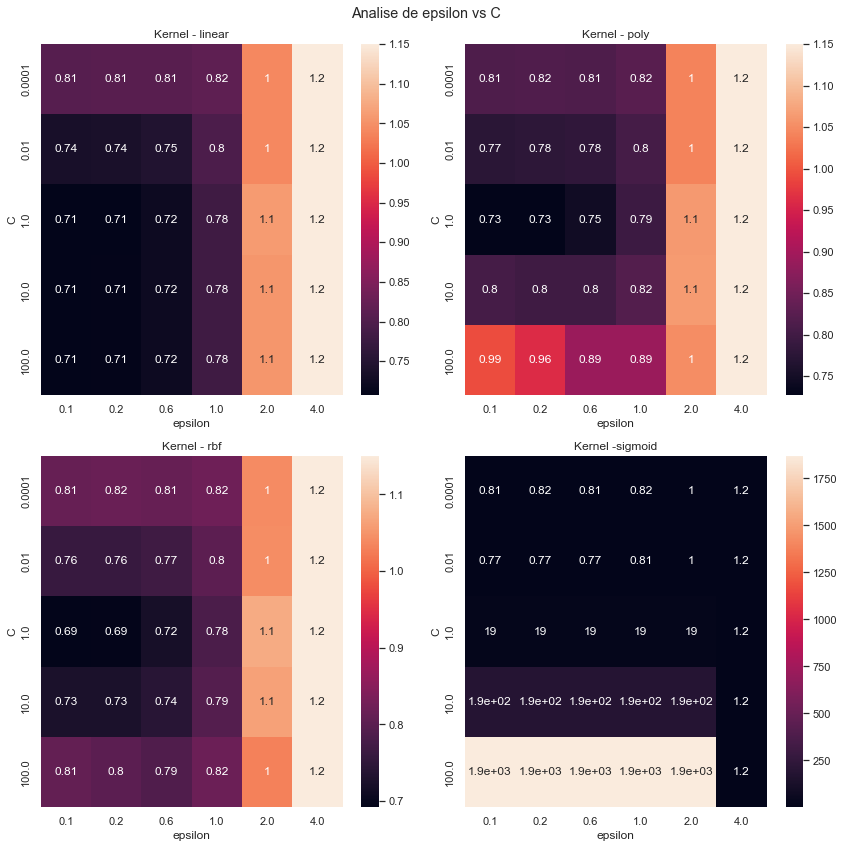

In [113]:
plot_vars(var_a = 'epsilon', var_b = 'C')

#### 01.02 - Epsilon vs C

In [121]:
pd.qcut(df_results['mean_test_score'], q = 10).value_counts().sort_index()

(0.691, 0.725]        12
(0.725, 0.768]        12
(0.768, 0.794]        12
(0.794, 0.809]        12
(0.809, 0.818]        12
(0.818, 1.041]        12
(1.041, 1.067]        12
(1.067, 1.15]         21
(1.15, 18.712]         3
(18.712, 1870.658]    12
Name: mean_test_score, dtype: int64

#### 10% melhores classificadores

In [122]:
df_results[df_results['mean_test_score'] <= 0.725]

,mean_test_score,C,epsilon,kernel
48,0.707067,1.0,0.1,linear
50,0.691855,1.0,0.1,rbf
52,0.707200,1.0,0.2,linear
54,0.694784,1.0,0.2,rbf
56,0.722091,1.0,0.6,linear
58,0.719491,1.0,0.6,rbf
72,0.707942,10.0,0.1,linear
76,0.708894,10.0,0.2,linear
80,0.722261,10.0,0.6,linear
96,0.707993,100.0,0.1,linear


In [19]:
np.random.seed(1082141)
sns.set()

**Atividade (2 pts):** Treine 2 outros regressores a sua escolha (Regressão linear, polinomial, árvore de regeressão, etc.) e compare o resultado dos modelos com a sua melhor SVR no conjunto de teste, discuntindo os resultados.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

## PARTE II - Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [20]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



### 256 primeiras amostras no conjunto de treinamento

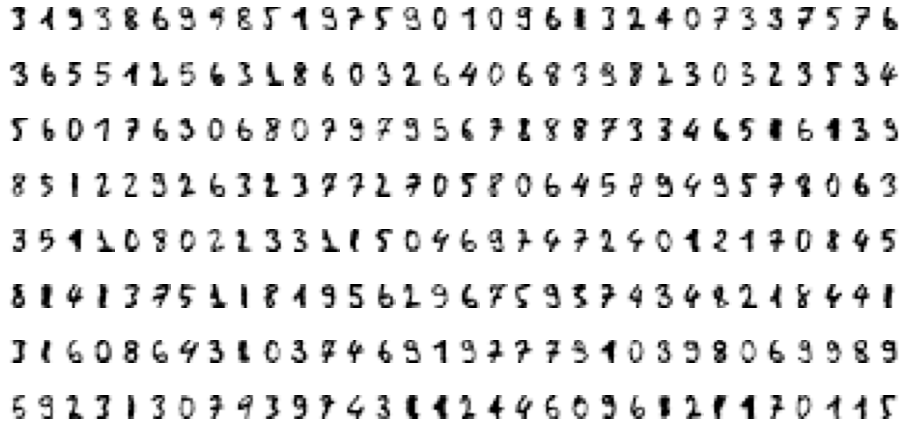

In [21]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments withou

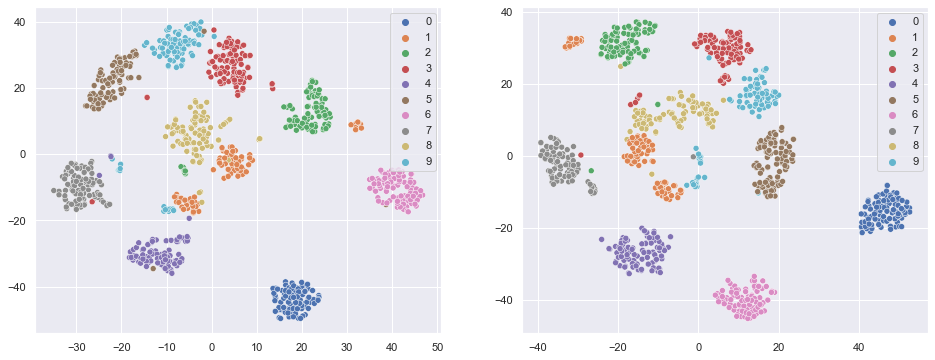

In [22]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


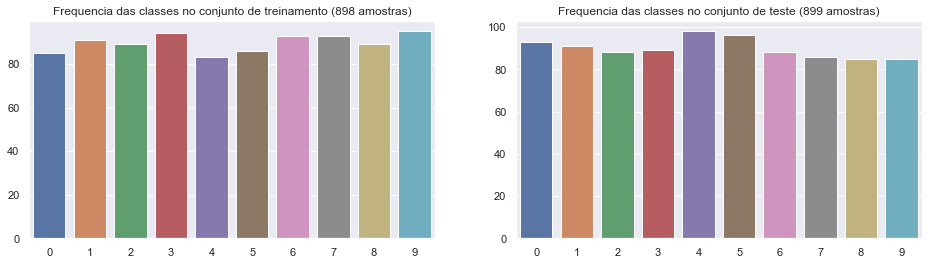

In [23]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos com SVM Linear

**Atividade (1 pt):** defina e treine uma máquina de vetor de suporte com kernel linear, utilizando o scikit-learn. Encontre o melhor valor do parâmetro C, definindo um intervalo de busca e fazendo um grid search com validação cruzada em 10 folds.

### Avaliando o modelo treinado

**Atividade (1 pt):** avalie o modelo treinado com o melhor valor encontrado para o parâmetro C sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão.

### Modelando um classificador de digitos com SVM com kernel RBF

**Atividade (1 pt):** utilizando o kernel RBF, defina e treine uma máquina de vetor de suporte. Faça um grid search nos valores de C e gamma com validação cruzada em 10 folds.

**Atividade (1 pt):** aumente o intervalo de busca de C e gamma e faça uma busca randômica pelo intervalo. 

### Avaliando os melhores modelos

**Atividade (1 pt):** utilizando o melhor par de valores encontrado para C e gamma, em cada uma das estratégias, treine e avalie um modelo sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão para com cada modelo.